# **Economic Car Accidents**

# **Reseach Question**

**(1) How significant of an impact do economic factors have on the frequency and magnitude of car accidents that occur in the United States?**

**(2) Do certain makes of cars tend to get in more car accidents than other?**


# **Background and Prior Research**


When you think of transportation in the United States, the first thing that comes to mind are cars. With over 250 million registered vehciles in the country, it remains the most common method of transportation to date. With this many vehiciles, we also face an ever increasing number of car accidents. With millions of accidents being reported, insruance companies have used this data to figure out in which situations accidents are more likely to occur. 

However, one factor that nobody ever really correlates with car accidents, is the economy. An article from *The Los Angeles Times* estimated that in 2014, car accidents tend to have an economoic toll of almost $1 trillion dollars (Fleming). These costs add up based off several factors, such as medical expenses, property damage, and air pollution just to name a few. While there are several indicators of how car accidents affect our economy, we wanted to see if the economy had an impact on the number of accidents that occur in a given year.


Sources: https://www.latimes.com/business/autos/la-fi-hy-economic-impact-of-traffic-accidents-20140529-story.html

**Notes:**

The only real trend that studies have shown between cars and the economy is that people are more likely to purchase a new car when the economy is doing well. 

**Potential Comparisons/Analysis Ideas:**
1. Unemployment rates vs. accidents per month/year
  a. we have both yearly avg and monthly rates so we can just filter all accidents in the given time frame and make month to month comparisons of the rate and the # of accidents
  b. 

2. Use multiple lienar regression and use economic factors and correlate with the number of accidents per year or month

3. Use some ML and try to predict what 2020 will be like 



# Datasets

**Accidents:**  https://www.kaggle.com/sobhanmoosavi/us-accidents

**Unemployment Rates Yearly:** https://data.bls.gov/timeseries/LNU04023554&series_id=LNU04000000&series_id=LNU03023554&series_id=LNU03000000&years_option=all_years&periods_option=specific_periods&periods=Annual+Data

**GDP Data:** https://www.thebalance.com/us-gdp-by-year-3305543

**Inflation Rates:** https://www.usinflationcalculator.com/inflation/current-inflation-rates/


# **Data Cleaning**

# **Setup & Packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

In [2]:
#Import all Datasets
df_Accidents = pd.read_csv('US_Accidents_June20.csv')
df_Unemployment = pd.read_excel('UnemploymentRates.xlsx')
df_Unemployment_Rate = pd.read_excel('UnemployedYearlyRates.xlsx')
df_Inflation_Rates = pd.read_excel('InflationRates.xlsx')

In [90]:
#Scrape for GDP data
GDP_URL = 'https://www.thebalance.com/us-gdp-by-year-3305543'
page = requests.get(GDP_URL)
soup = BeautifulSoup(page.text, 'html.parser')


gdp_Table = soup.find('table', attrs={'class':"mntl-sc-block-table__table"})
list_a, list_b, list_c, list_d = [], [], [], []

for row in gdp_Table.findAll('tr'):

  cells=row.findAll('td')

  try:
    list_a.append(cells[0].find(text=True))
    list_b.append(cells[1].find(text=True))
    list_c.append(cells[2].find(text=True))
    list_d.append(cells[3].find(text=True))
  except:
    break

df_GDP = pd.DataFrame({
    'Year' : list_a,
    'Nominal_GDP' : list_b,
    'Real_GDP' : list_c,
    'GDP Growth Rate' : list_d
})

df_GDP = df_GDP.iloc[1:]

#Convert to int values
df_GDP['Year'] = pd.to_numeric(df_GDP['Year'])


#Might have to convert to string and then integer to remove '$' and store as integer
#df_GDP.Nominal_GDP.str.replace('$','')
#df_GDP.Real_GDP.str.replace('$','')

#df_GDP['Nominal_GDP'] = pd.to_numeric(df_GDP['Nominal_GDP'])
#df_GDP['Real_GDP'] = pd.to_numeric(df_GDP['Real_GDP'])

def remove_dolSign(dollar):
    dollar = str(dollar)
    dollar = dollar.replace('$','')
    dollar = dollar.replace(',','.')

    return float(dollar)

df_GDP = df_GDP[df_GDP['Year'] > 1999]

df_GDP.dtypes
df_GDP.head()


,Year,Nominal_GDP,Real_GDP,GDP Growth Rate
72,2000,$10.252,$13.131,4.1%
73,2001,$10.582,$13.262,1.0%
74,2002,$10.936,$13.493,1.7%
75,2003,$11.458,$13.879,2.9%
76,2004,$12.214,$14.406,3.8%


In [91]:
df_GDP['Nominal_GDP'] = df_GDP['Nominal_GDP'].apply(remove_dolSign)
df_GDP['Real_GDP'] = df_GDP['Real_GDP'].apply(remove_dolSign)
df_GDP

,Year,Nominal_GDP,Real_GDP,GDP Growth Rate
72,2000,10.252,13.131,4.1%
73,2001,10.582,13.262,1.0%
74,2002,10.936,13.493,1.7%
75,2003,11.458,13.879,2.9%
76,2004,12.214,14.406,3.8%
77,2005,13.037,14.913,3.5%
78,2006,13.815,15.338,2.9%
79,2007,14.452,15.626,1.9%
80,2008,14.713,15.605,-0.1%
81,2009,14.449,15.209,-2.5%


In [87]:
def year_split(start):
    date = str(start)
    split = date.split(' ')
    year = split[0].split('-')
    month = year[1]
    return int(year[0])

def month_split(start):
    date = str(start)
    split = date.split(' ')
    year = split[0].split('-')
    month = year[1]
    return int(month)


In [10]:
df_Accidents = df_Accidents.assign(Year = df_Accidents.get('Start_Time').apply(year_split), Month = df_Accidents.get('Start_Time').apply(month_split))
df_Accidents_Yearly = df_Accidents.groupby('Year').count().reset_index()
df_accidents = df_Accidents[['Year','Month','Start_Time', 'Severity','Start_Lat', 'Start_Lng','State','Zipcode', 'Timezone']]
df_accidents

,Year,Month,Start_Time,Severity,Start_Lat,Start_Lng,State,Zipcode,Timezone
0,2016,2,2016-02-08 05:46:00,3,39.865147,-84.058723,OH,45424,US/Eastern
1,2016,2,2016-02-08 06:07:59,2,39.928059,-82.831184,OH,43068-3402,US/Eastern
2,2016,2,2016-02-08 06:49:27,2,39.063148,-84.032608,OH,45176,US/Eastern
3,2016,2,2016-02-08 07:23:34,3,39.747753,-84.205582,OH,45417,US/Eastern
4,2016,2,2016-02-08 07:39:07,2,39.627781,-84.188354,OH,45459,US/Eastern
...,...,...,...,...,...,...,...,...,...
3513612,2019,8,2019-08-23 18:03:25,2,34.002480,-117.379360,CA,92501,US/Pacific
3513613,2019,8,2019-08-23 19:11:30,2,32.766960,-117.148060,CA,92108,US/Pacific
3513614,2019,8,2019-08-23 19:00:21,2,33.775450,-117.847790,CA,92866,US/Pacific
3513615,2019,8,2019-08-23 19:00:21,2,33.992460,-118.403020,CA,90230,US/Pacific


In [24]:
#Convert start/end_time from object to datetime object so we can run time queries easier
#df_Accidents['Start_Time'] = pd.to_datetime(df_Accidents['Start_Time'])
print(df_Accidents[df_Accidents['Start_Time'].str.len() > 19].count())
#df_Accidents_Yearly = df_Accidents.groupby(df_Accidents.Start_Time.dt.year)
#df_Accidents_Yearly.head()
#df_Accidents.dtypes

ID                       0
Source                   0
TMC                      0
Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
End_Lat                  0
End_Lng                  0
Distance(mi)             0
Description              0
Number                   0
Street                   0
Side                     0
City                     0
County                   0
State                    0
Zipcode                  0
Country                  0
Timezone                 0
Airport_Code             0
Weather_Timestamp        0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
N

In [25]:
#We can consolidate this into one graph if we fix datetime error above

#2016
df_2016 = df_accidents[df_accidents.get('Year') == 2016]
df_2016 = df_2016.groupby('Month').count().reset_index()
#df_2016 = df_2016[['Month']]
#df_2016 = df_2016.assign(Count = df_2016.get('Year'))
#2017
df_2017 = df_accidents[df_accidents.get('Year') == 2017]
df_2017 = df_2017.groupby('Month').count().reset_index()
#2018
df_2018 = df_accidents[df_accidents.get('Year') == 2018]
df_2018 = df_2018.groupby('Month').count().reset_index()
#2019
df_2019 = df_accidents[df_accidents.get('Year') == 2019]
df_2019 = df_2019.groupby('Month').count().reset_index()

In [26]:
df_2016

,Month,Year,Start_Time,Severity,Start_Lat,Start_Lng,State,Zipcode,Timezone
0,2,985,985,985,985,985,985,985,985
1,3,6329,6329,6329,6329,6329,6329,6327,6327
2,4,18088,18088,18088,18088,18088,18088,18080,18080
3,5,17610,17610,17610,17610,17610,17610,17608,17608
4,6,30527,30527,30527,30527,30527,30527,30521,30521
5,7,45759,45759,45759,45759,45759,45759,45745,45741
6,8,56425,56425,56425,56425,56425,56425,56408,56405
7,9,54664,54664,54664,54664,54664,54664,54645,54643
8,10,55628,55628,55628,55628,55628,55628,55615,55614
9,11,65010,65010,65010,65010,65010,65010,64997,64997


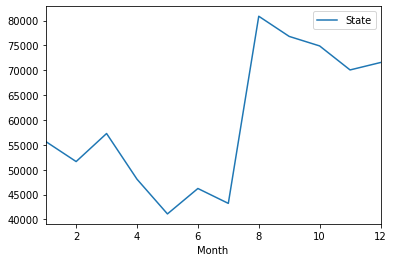

In [33]:
df_2017.plot.line(x = 'Month', y = 'State')

[Text(0, 0, '2000'),
 Text(0, 0, '2001'),
 Text(0, 0, '2002'),
 Text(0, 0, '2003'),
 Text(0, 0, '2004'),
 Text(0, 0, '2005'),
 Text(0, 0, '2006'),
 Text(0, 0, '2007'),
 Text(0, 0, '2008'),
 Text(0, 0, '2009'),
 Text(0, 0, '2010'),
 Text(0, 0, '2011'),
 Text(0, 0, '2012'),
 Text(0, 0, '2013'),
 Text(0, 0, '2014'),
 Text(0, 0, '2015'),
 Text(0, 0, '2016'),
 Text(0, 0, '2017'),
 Text(0, 0, '2018'),
 Text(0, 0, '2019')]

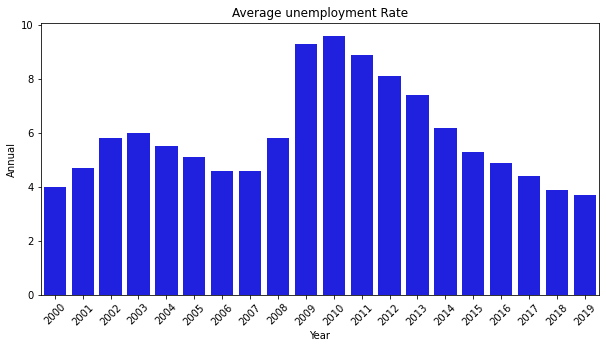

In [4]:
plt.figure(figsize=(10,5))
df_Unemployment_Rate = df_Unemployment_Rate[df_Unemployment_Rate['Year'] > 1999]
ax = sns.barplot(x=df_Unemployment_Rate['Year'], y=df_Unemployment_Rate['Annual'],
            data=df_Unemployment_Rate, ci=None, color='blue')

ax.set_title('Average Unemployment Rate')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)




In [92]:
df_gdp = df_GDP[df_GDP.get('Year') >= 2016].reset_index().drop(columns = 'index')

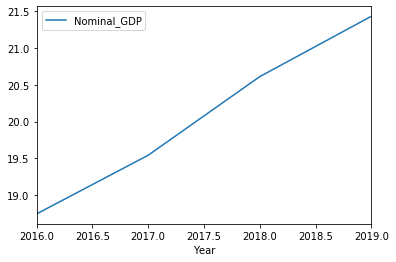

In [93]:
df_gdp.plot.line(x = 'Year', y = 'Nominal_GDP')